### Imports

In [143]:
# Basic Libraries
import pandas as pd
import numpy as np
import os

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Model Persistence
import joblib

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score
)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Optimization Libraries
import optuna

# External Dataset Downloading
import opendatasets as od

# Progress Bar
from tqdm import tqdm as notebook_tqdm

# Set Plotting Defaults
sns.set(rc={'figure.figsize': (16, 8)})
sns.set_style("darkgrid")

In [3]:
import os

def list_folders_and_files(directory):
    """
    List all folders, subfolders, and files in the specified directory without duplication.
    
    Args:
        directory (str): The root directory to start listing.
    """
    seen_directories = set()  # To keep track of visited directories
    for root, dirs, files in os.walk(directory):
        # Avoid duplicate directories
        if root in seen_directories:
            continue
        seen_directories.add(root)

        # Calculate the indentation level for the folder hierarchy
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")  # Print folder name
        
        # Print files in the current directory
        sub_indent = ' ' * 4 * (level + 1)
        for f in sorted(files):  # Sort files alphabetically
            print(f"{sub_indent}{f}")
        # Sort directories alphabetically to avoid potential reordering
        dirs.sort()

# Specify the root directory of your project
project_directory = input("Enter the path to your project directory: ")
list_folders_and_files(project_directory)


capstone_1/
    .gitignore
    Dockerfile
    README.md
    air_quality_env.yml
    requirements.txt
    data/
        processed/
            X_test.pkl
            X_test_scaled.csv
            X_train.pkl
            X_train_scaled.csv
            X_val.pkl
            X_val_scaled.csv
            best_f1.pkl
            best_params.pkl
            label_encoder.pkl
            scaler.pkl
            y_test.csv
            y_test.pkl
            y_train.csv
            y_train.pkl
            y_val.csv
            y_val.pkl
        raw/
            air-quality-and-pollution-assessment/
                updated_pollution_dataset.csv
    models/
        best_model.pkl
    notebooks/
        notebook.ipynb
        notebook.py
        catboost_info/
            catboost_training.json
            learn_error.tsv
            time_left.tsv
            learn/
                events.out.tfevents
            tmp/
    src/
        predict.py
        train.py


## Data Loading and Preprocessing

In [16]:
# Define the desired path for the raw data folder
raw_data_folder = r"C:\Users\User\ml-zoomcamp\capstone_1\data\raw"

# Ensure the raw data folder exists
os.makedirs(raw_data_folder, exist_ok=True)

# Download the dataset into the raw data folder
dataset_url = 'https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment/data'
od.download(dataset_url, data_dir=raw_data_folder)

print(f"Dataset downloaded and stored in: {raw_data_folder}")

Skipping, found downloaded files in "C:\Users\User\ml-zoomcamp\capstone_1\data\raw\air-quality-and-pollution-assessment" (use force=True to force download)
Dataset downloaded and stored in: C:\Users\User\ml-zoomcamp\capstone_1\data\raw


In [99]:
# Load the dataset
df = pd.read_csv(r"C:\Users\User\ml-zoomcamp\capstone_1\data\raw\air-quality-and-pollution-assessment\updated_pollution_dataset.csv")
df.head()

Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good

In [100]:
# Check the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [101]:
# Check for missing values
df.isnull().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

No missing values.

In [102]:
# Transform column names: make lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns

Index(['temperature', 'humidity', 'pm2.5', 'pm10', 'no2', 'so2', 'co',
       'proximity_to_industrial_areas', 'population_density', 'air_quality'],
      dtype='object')

## Exploratory Data Analysis (EDA)

In [103]:
# Check basic information about registration_data_test dataset
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print('='*40)
print ("Features : \n" ,df.columns.tolist())
print('='*40)
print ("Unique values :  \n",df.nunique())

Rows     :  5000
Columns  :  10
Features : 
 ['temperature', 'humidity', 'pm2.5', 'pm10', 'no2', 'so2', 'co', 'proximity_to_industrial_areas', 'population_density', 'air_quality']
Unique values :  
 temperature                      362
humidity                         723
pm2.5                            815
pm10                             955
no2                              445
so2                              348
co                               265
proximity_to_industrial_areas    179
population_density               683
air_quality                        4
dtype: int64


In [104]:
# Check summary statistics
df.describe().T

count        mean         std     min     25%  \
temperature                    5000.0   30.029020    6.720661   13.40   25.10   
humidity                       5000.0   70.056120   15.863577   36.00   58.30   
pm2.5                          5000.0   20.142140   24.554546    0.00    4.60   
pm10                           5000.0   30.218360   27.349199   -0.20   12.30   
no2                            5000.0   26.412100    8.895356    7.40   20.10   
so2                            5000.0   10.014820    6.750303   -6.20    5.10   
co                             5000.0    1.500354    0.546027    0.65    1.03   
proximity_to_industrial_areas  5000.0    8.425400    3.610944    2.50    5.40   
population_density             5000.0  497.423800  152.754084  188.00  381.00   

                                  50%      75%     max  
temperature                     29.00   34.000   58.60  
humidity                        69.80   80.300  128.10  
pm2.5                           12.00   26.100  295.00  
pm10                            21.70   38.100  315.80  
no2                             25.30   31.900   64.90  
so2                              8.00   13.725   44.90  
co                               1.41    1.840    3.72  
proximity_to_industrial_areas    7.90   11.100   25.80  
population_density             494.00  600.000  957.00

In [105]:
# Count negative values in the "pm10" and "so2" columns
negative_values_count = {
    "pm10": (df['pm10'] < 0).sum(),
    "so2": (df['so2'] < 0).sum()
}

negative_values_count

{'pm10': 1, 'so2': 30}

In [106]:
# Replace negative values with the minimum positive value in each column
df['pm10'] = df['pm10'].apply(lambda x: x if x >= 0 else df[df['pm10'] > 0]['pm10'].min())
df['so2'] = df['so2'].apply(lambda x: x if x >= 0 else df[df['so2'] > 0]['so2'].min())

# Check summary statistics
df.describe().T 

count        mean         std     min     25%  \
temperature                    5000.0   30.029020    6.720661   13.40   25.10   
humidity                       5000.0   70.056120   15.863577   36.00   58.30   
pm2.5                          5000.0   20.142140   24.554546    0.00    4.60   
pm10                           5000.0   30.218420   27.349133    0.00   12.30   
no2                            5000.0   26.412100    8.895356    7.40   20.10   
so2                            5000.0   10.021320    6.739359    0.00    5.10   
co                             5000.0    1.500354    0.546027    0.65    1.03   
proximity_to_industrial_areas  5000.0    8.425400    3.610944    2.50    5.40   
population_density             5000.0  497.423800  152.754084  188.00  381.00   

                                  50%      75%     max  
temperature                     29.00   34.000   58.60  
humidity                        69.80   80.300  128.10  
pm2.5                           12.00   26.100  295.00  
pm10                            21.70   38.100  315.80  
no2                             25.30   31.900   64.90  
so2                              8.00   13.725   44.90  
co                               1.41    1.840    3.72  
proximity_to_industrial_areas    7.90   11.100   25.80  
population_density             494.00  600.000  957.00

## Feature-Specific Insights
### Temperature:
- Mean: ~30°C, with a range from 13.4°C to 58.6°C.
- Variation: Moderate, with a standard deviation of 6.72.
- Interpretation: Captures a mix of climates, indicating potential impact on pollutant dispersion and chemical reactions.

### Humidity:
- Mean: ~70%, ranging from 36% to 128.1%.
- Variation: Moderate-to-high, with a standard deviation of 15.86.
- Interpretation: High humidity levels may correlate with pollutant dispersion and secondary reactions (e.g., smog formation).

### PM10 (Coarse Particulate Matter):
- Mean: ~30.22 µg/m³, ranging from 0 to 315.8 µg/m³.
- Variation: High, with a standard deviation of 27.35.
- Impact of Replacement: Negative values were replaced with minimum positive value of PM10, without affecting the mean and variance.
- Interpretation: Reflects significant variability in particulate pollution across regions.

### NO2 (Nitrogen Dioxide):
- Mean: ~26.41 ppb, ranging from 7.4 to 64.9 ppb.
- Variation: Moderate, with a standard deviation of 8.89.
- Interpretation: Common pollutant from vehicle emissions and industrial activity.

### SO2 (Sulfur Dioxide):
- Mean: ~10.02 ppb, ranging from 0 to 44.9 ppb.
- Variation: Moderate-to-high, with a standard deviation of 6.74.
- Impact of Replacement: Negative values were replaced with 5.1 ppb, without affecting the mean and variance.
- Interpretation: Suggests areas with moderate-to-high industrial activity.

### CO (Carbon Monoxide):
- Mean: ~1.50 ppm, ranging from 0.65 to 3.72 ppm.
- Variation: Low-to-moderate, with a standard deviation of 0.55.
- Interpretation: Indicates moderate levels of incomplete combustion sources.

### Proximity to Industrial Areas:
- Mean: ~8.43 km, ranging from 2.5 to 25.8 km.
- Variation: Moderate, with a standard deviation of 3.61.
- Interpretation: Industrial proximity may explain higher pollutant levels in nearby areas.

### Population Density:
- Mean: ~497 people/km², ranging from 188 to 957 people/km².
- Variation: Moderate, with a standard deviation of 152.75.
- Interpretation: Population density likely influences residential and vehicular emissions.

In [107]:
# Plot distributions for numerical features
def plot_distributions(data, features):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.histplot(data[feature], kde=True, bins=30)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.show()

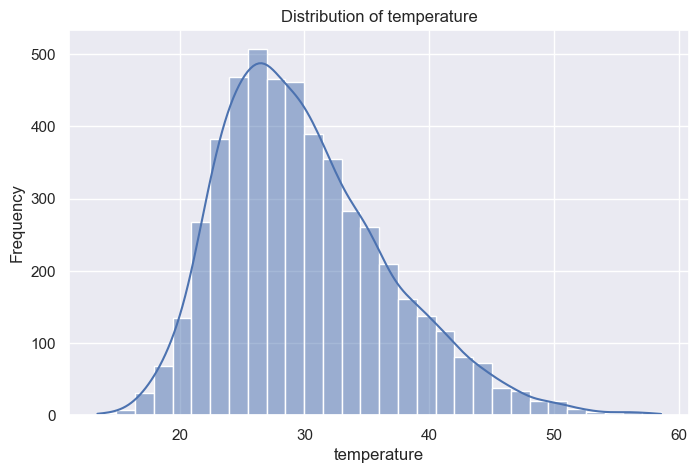

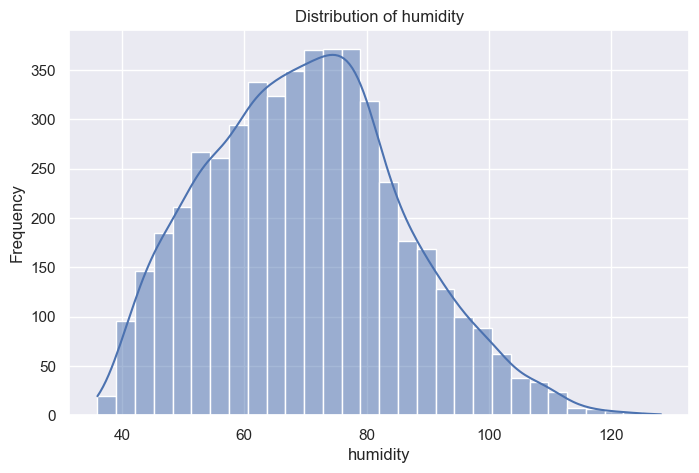

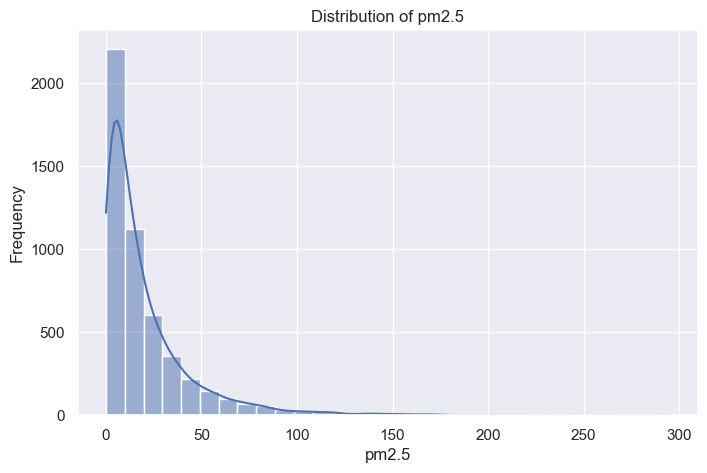

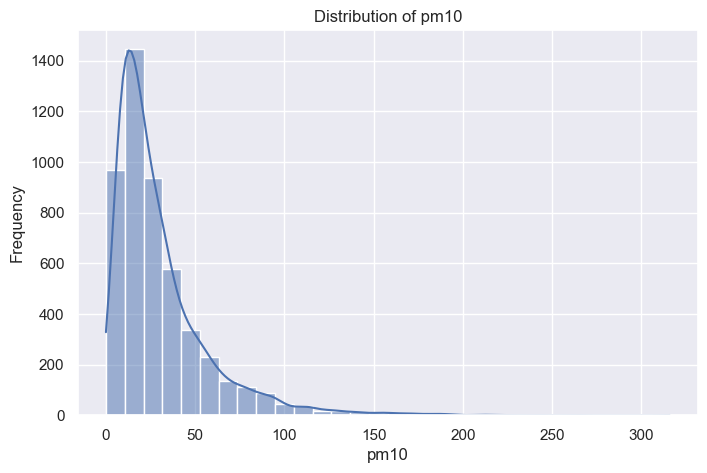

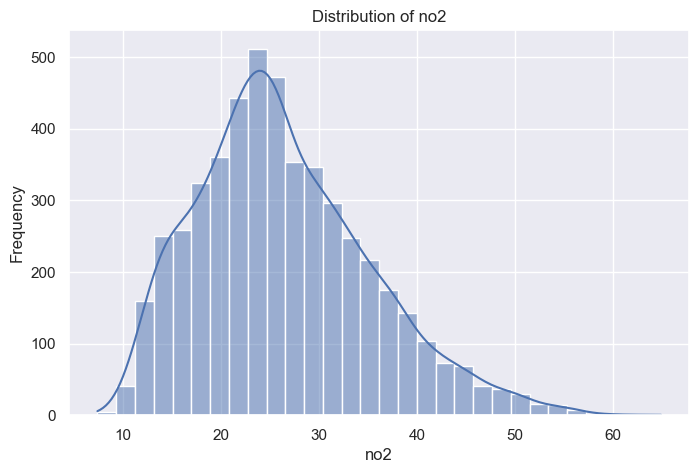

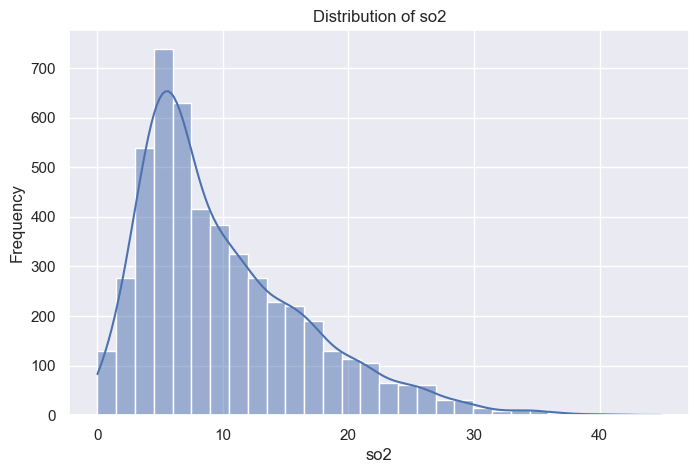

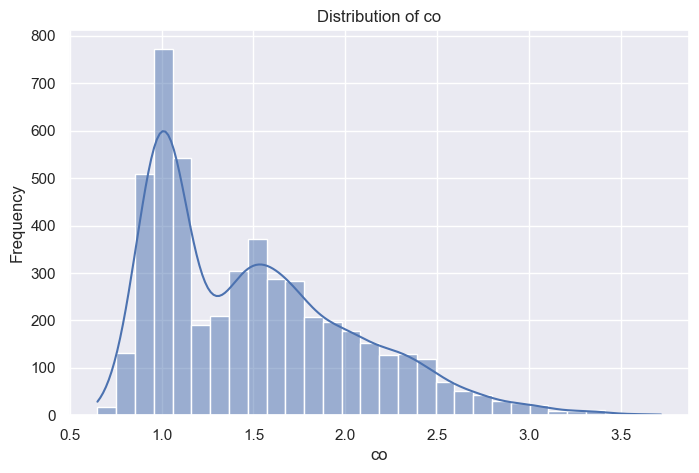

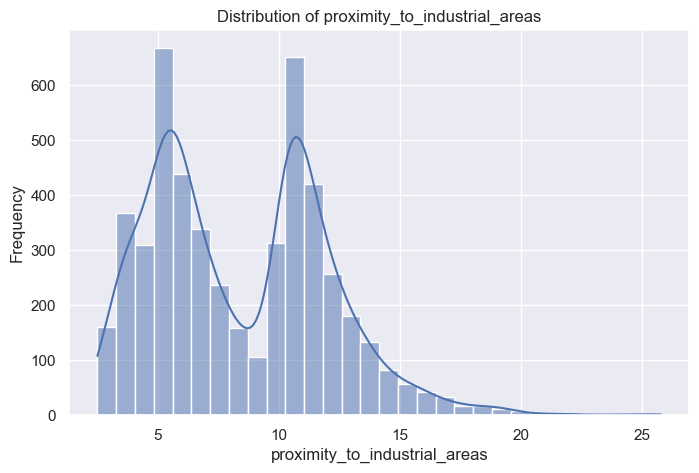

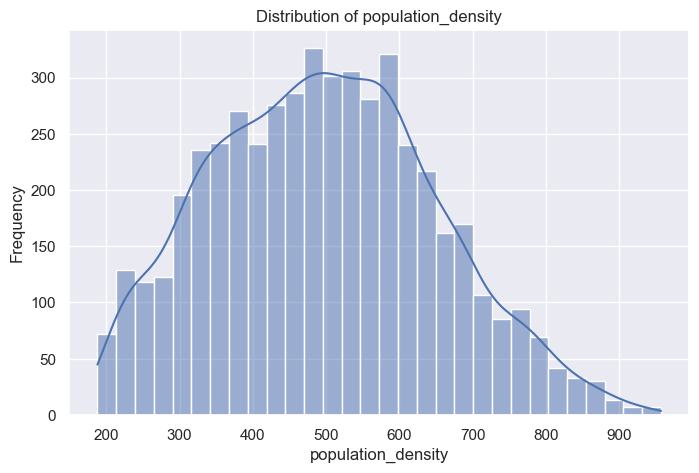

In [108]:
# Select numerical features for visualization
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
plot_distributions(df, numerical_features)

### General Observations:
- Many features (e.g., PM2.5, PM10, SO2, and CO) have skewed distributions with extreme outliers. 
- Proximity to industrial areas shows a unique bimodal distribution, which may suggest two distinct population groups (urban vs. rural).
- The use of robust models like CatBoost, XGBoost, LightGBM, and Random Forest are inherently less sensitive to outliers due to their algorithmic structures. Hence, outlier removal or transformation is generally unnecessary in our case.

In [109]:
# Bar plot for categorical features
def plot_categorical_distribution(data, feature):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, data=data) 
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

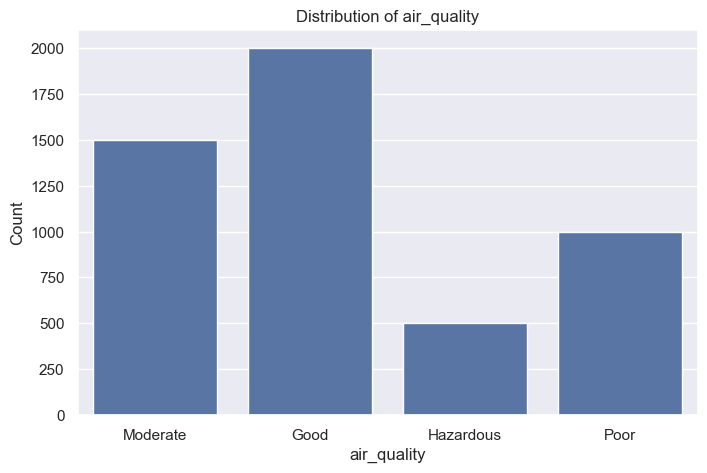

In [110]:
# Plot categorical features
categorical_features = df.select_dtypes(include=[object]).columns.tolist()
for feature in categorical_features:
    plot_categorical_distribution(df, feature)

In [111]:
# Check the distribution of the target variable
air_quality_count = df['air_quality'].value_counts()
air_quality_count

air_quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64

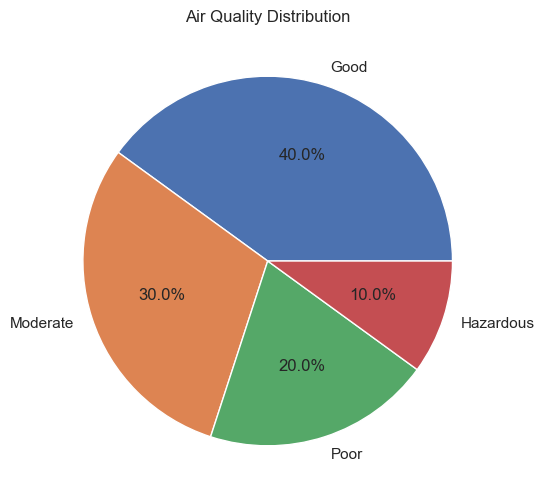

In [112]:
# Proportions of air quality levels
air_quality_proportions = df['air_quality'].value_counts(normalize=True)
air_quality_proportions.plot.pie(autopct="%.1f%%", figsize=(6, 6), title="Air Quality Distribution")
plt.ylabel("")
plt.show()


### Key Observations for target variable:

#### Target Variable: Air Quality

- Distribution:

The target variable "air_quality" has four categories: Good, Moderate, Poor and Hazardous.

- Imbalance:

The dataset is imbalanced, with the majority class (Good) accounting for 40% of the total samples.
The Hazardous class, which may represent critical air quality levels, is the minority class with only 10% of the data.

#### Impact on Modeling:

- Class Imbalance:
Models trained without addressing imbalance may favor the majority class (Good) and perform poorly on the minority class (Hazardous).

- Misclassification Costs:
Misclassifying Hazardous as Good or Moderate could lead to significant real-world consequences.

- Distribution Highlights:
Good and Moderate air quality levels dominate, suggesting many regions experience relatively clean air. Poor and Hazardous levels indicate regions with significant pollution, possibly near industrial zones or urban centers. 

### Actions for Modeling:
- Evaluation Metrics:

We will use weighted metrics (e.g., Weighted F1-score) to ensure all classes are represented fairly.
Evaluate per-class recall to measure the model's ability to identify Hazardous cases accurately.

- Handling Imbalance:

We will use class weights to handle the class imbalance.

- Model Selection:

Models like CatBoost, XGBoost, and LightGBM natively handle class imbalance through built-in parameters (e.g., scale_pos_weight).

In [113]:
# Plot boxplots for numerical features to identify outliers
def plot_boxplots(data, features):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=data[feature])
        plt.title(f"Boxplot of {feature}")
        plt.xlabel(feature)
        plt.show()

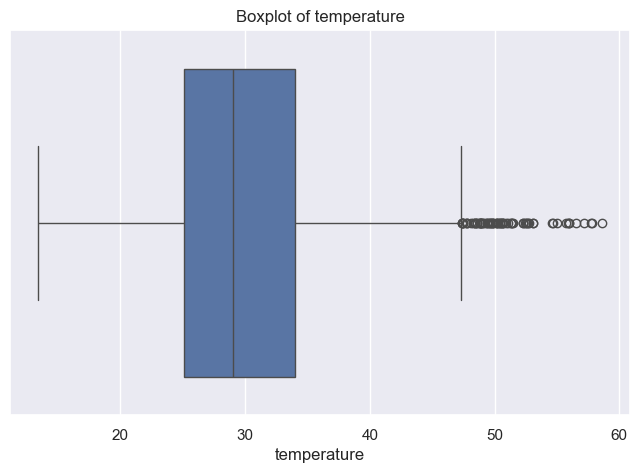

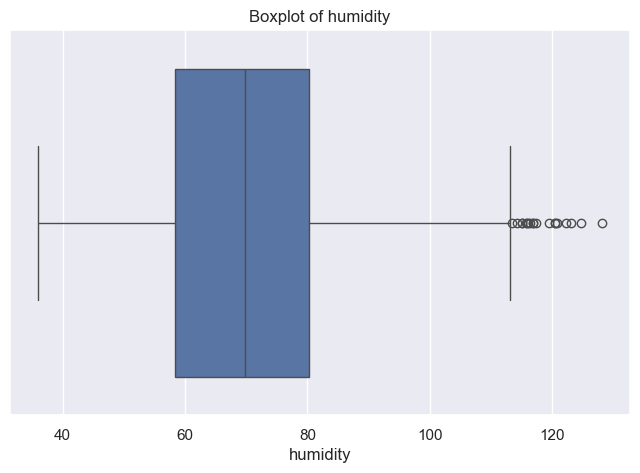

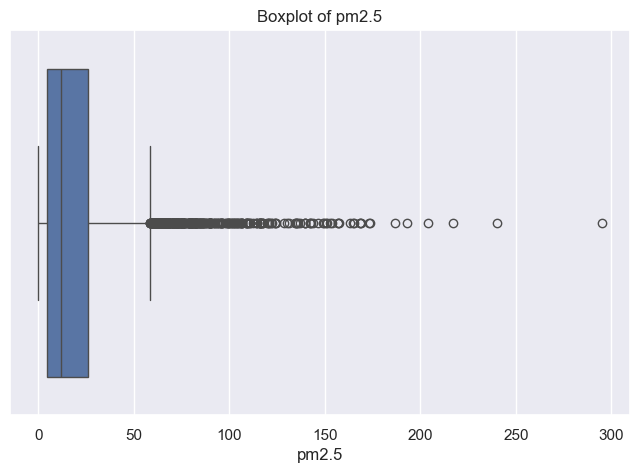

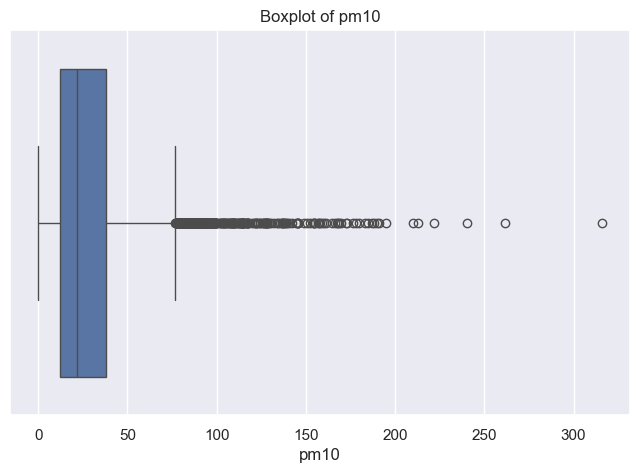

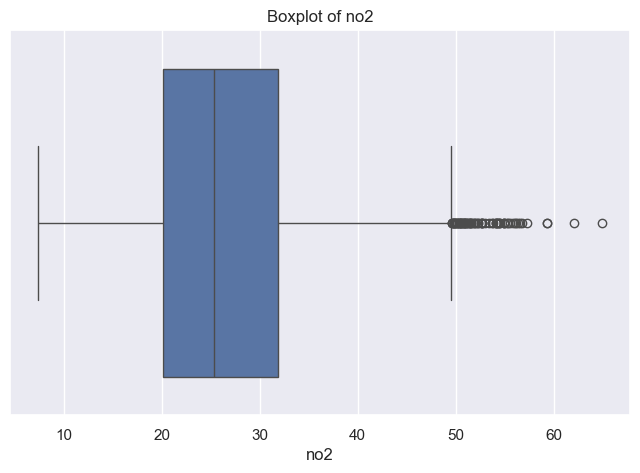

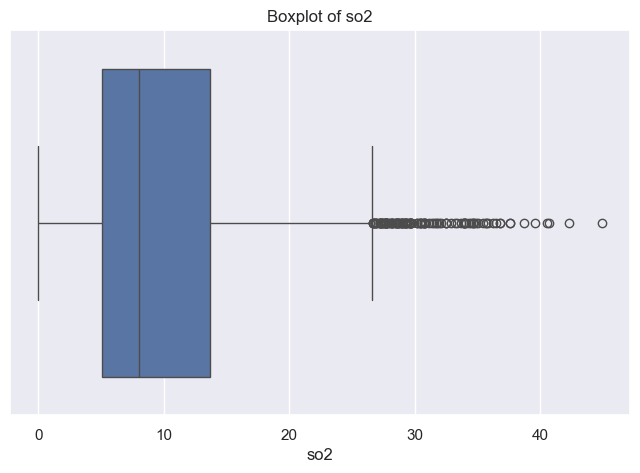

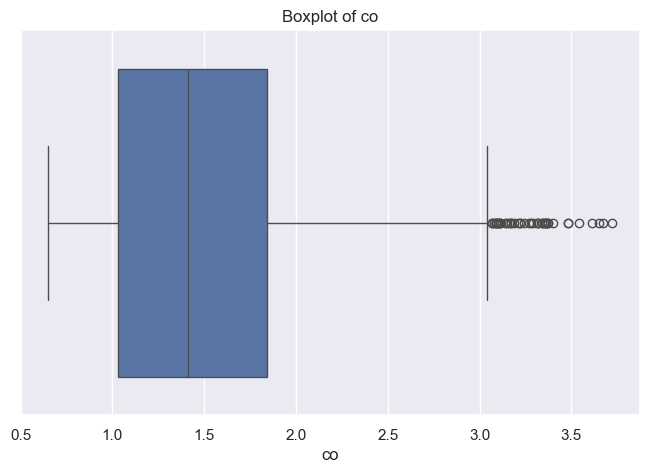

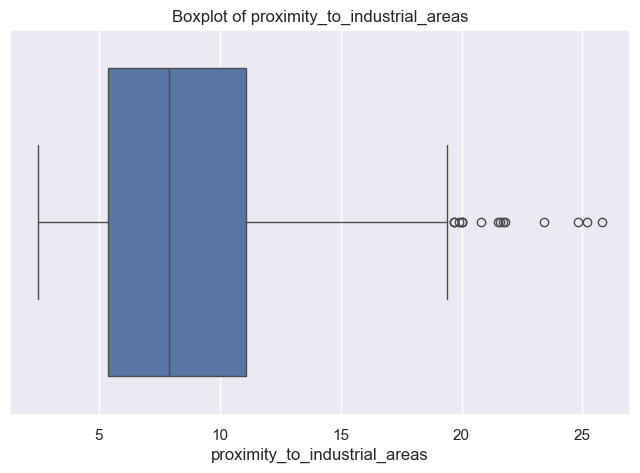

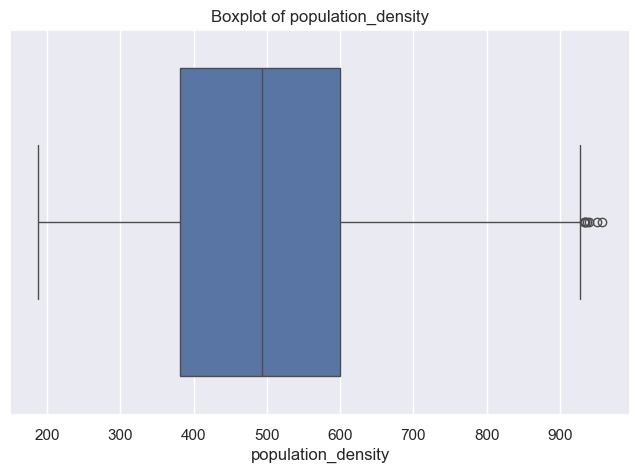

In [114]:
# Plot the boxplots
plot_boxplots(df, numerical_features)

In [115]:
# Selecting only numerical columns
numerical_columns = df.select_dtypes(include=[np.number])

In [116]:
# Calculating the Interquartile Range (IQR) for each numerical column
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding outliers by checking if values fall outside the bounds
outliers = (numerical_columns < lower_bound) | (numerical_columns > upper_bound)

# Printing outliers for each numerical column
for column in outliers.columns:
    print(f"Outliers in {column}:")
    print(df[outliers[column]][column])
    print()

Outliers in temperature:
29      52.5
55      48.1
67      58.6
106     49.6
249     50.9
        ... 
4664    49.1
4814    52.6
4892    50.2
4938    48.8
4945    47.5
Name: temperature, Length: 72, dtype: float64

Outliers in humidity:
509     120.5
865     116.9
960     115.0
1304    116.1
1892    115.7
2209    120.5
2278    128.1
2391    113.5
2957    116.9
3316    116.3
3397    117.3
3455    115.0
3474    120.7
3559    119.4
3693    124.7
3827    115.9
4275    122.3
4371    114.3
4815    123.0
Name: humidity, dtype: float64

Outliers in pm2.5:
29       67.5
33       84.4
35       83.3
42       68.9
49       70.7
        ...  
4960     71.6
4981     62.1
4986     74.5
4995    116.0
4999     81.7
Name: pm2.5, Length: 352, dtype: float64

Outliers in pm10:
29       91.2
33       94.4
35       93.5
42       85.2
49       84.8
        ...  
4955     87.6
4981     79.4
4986     93.3
4995    126.7
4999     94.3
Name: pm10, Length: 324, dtype: float64

Outliers in no2:
176     50.9
213    

In [117]:
# Calculating the number of outliers in each numerical column
num_outliers = outliers.sum()

# Computing the percentage of outliers in each numerical column
total_rows = df.shape[0]
percentage_outliers = (num_outliers / total_rows) * 100

# Creating a DataFrame to store the results
outlier_stats = pd.DataFrame({
    'Num_Outliers': num_outliers,
    'Percentage_Outliers': percentage_outliers
})

# Displaying the outlier statistics
print("Outlier Statistics:")
print(outlier_stats)

Outlier Statistics:
                               Num_Outliers  Percentage_Outliers
temperature                              72                 1.44
humidity                                 19                 0.38
pm2.5                                   352                 7.04
pm10                                    324                 6.48
no2                                      73                 1.46
so2                                     124                 2.48
co                                       45                 0.90
proximity_to_industrial_areas            16                 0.32
population_density                        7                 0.14


In [118]:
# Function to visualize outliers
def visualize_outliers(data, column, lower_bound, upper_bound):
    plt.figure(figsize=(12, 6))

    # Scatter plot to show outliers
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=data.index, y=data[column], color="blue")
    plt.axhline(lower_bound[column], color="red", linestyle="--", label="Lower Bound")
    plt.axhline(upper_bound[column], color="green", linestyle="--", label="Upper Bound")
    plt.title(f"Scatter Plot of {column} (with Outliers)")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()

    # Boxplot to visualize outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color="lightblue")
    plt.title(f"Boxplot of {column}")

    plt.tight_layout()
    plt.show()

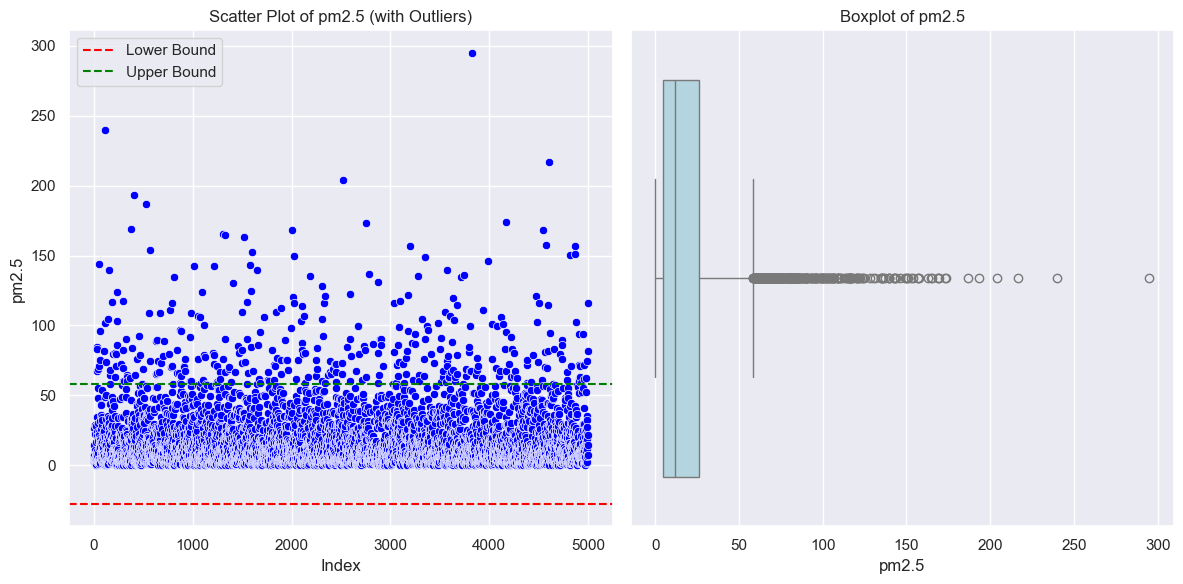

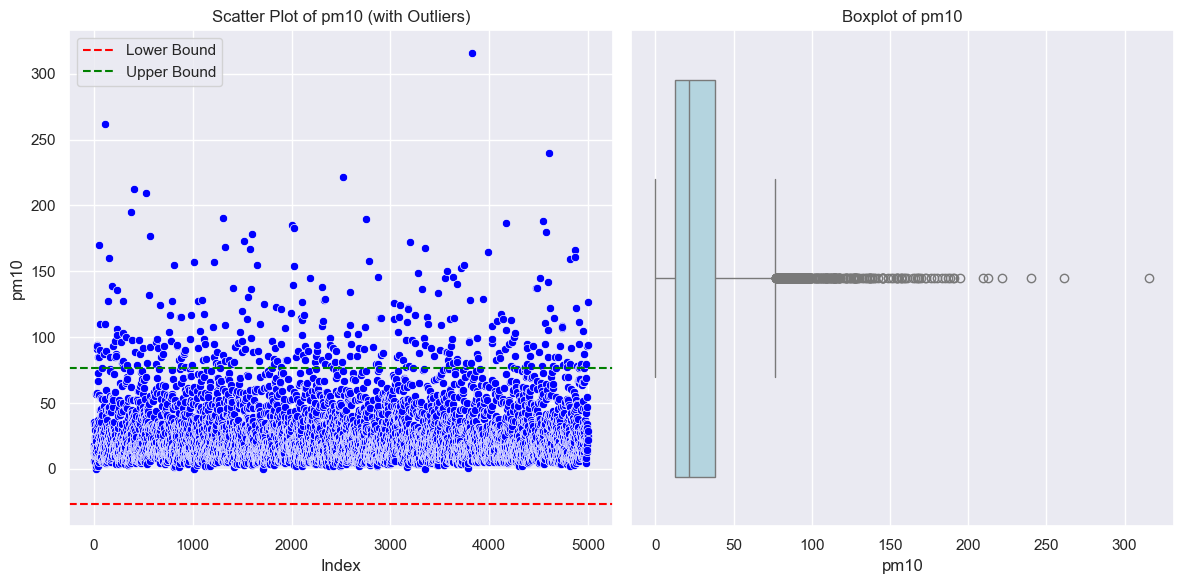

In [119]:
# Visualize outliers for affected columns
for col in ['pm2.5', 'pm10']:
    visualize_outliers(df, col, lower_bound, upper_bound)

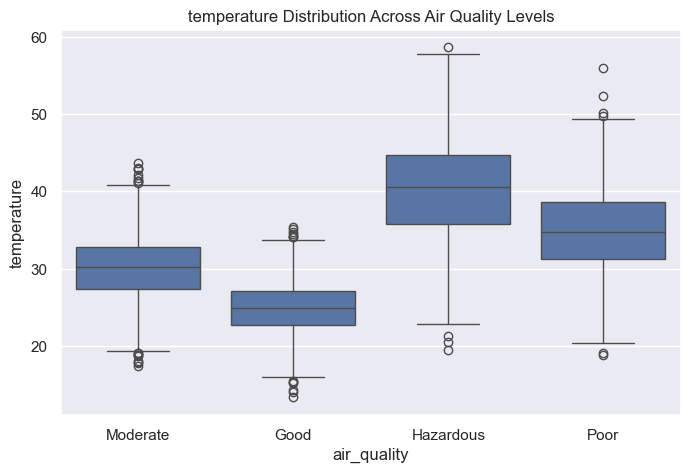

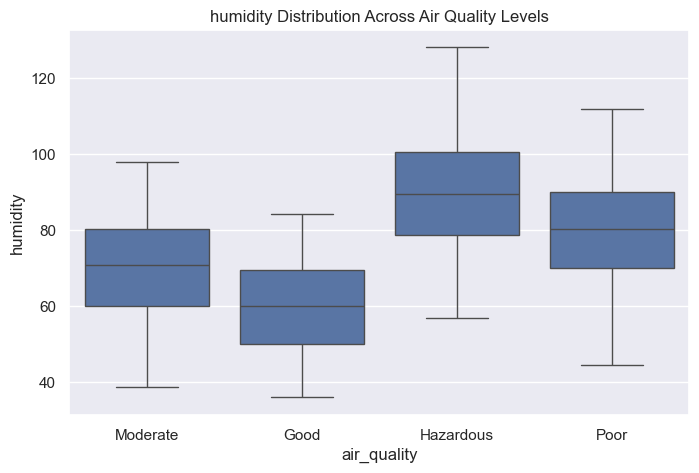

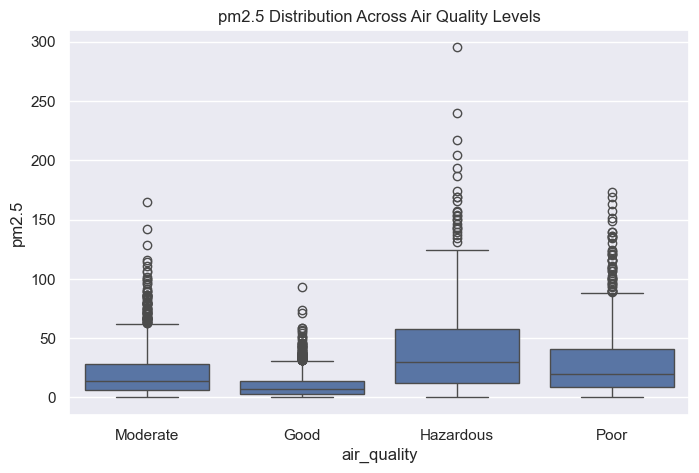

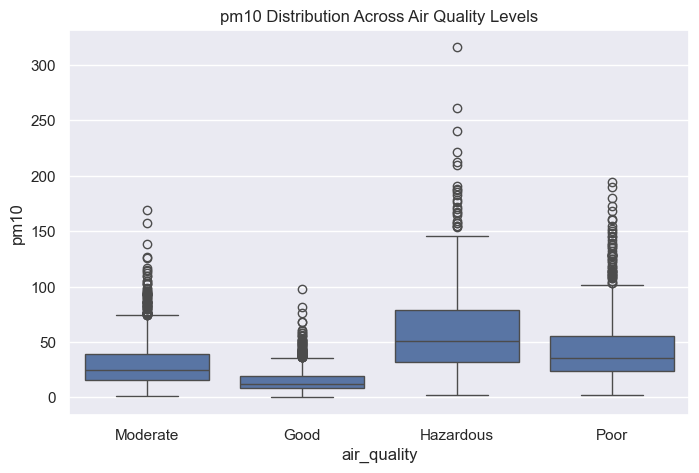

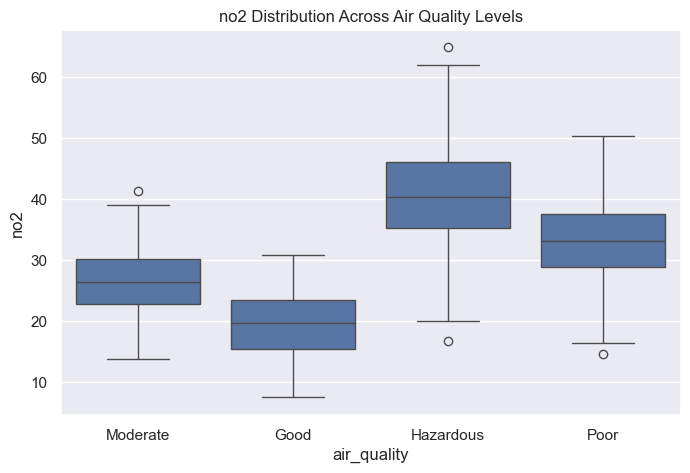

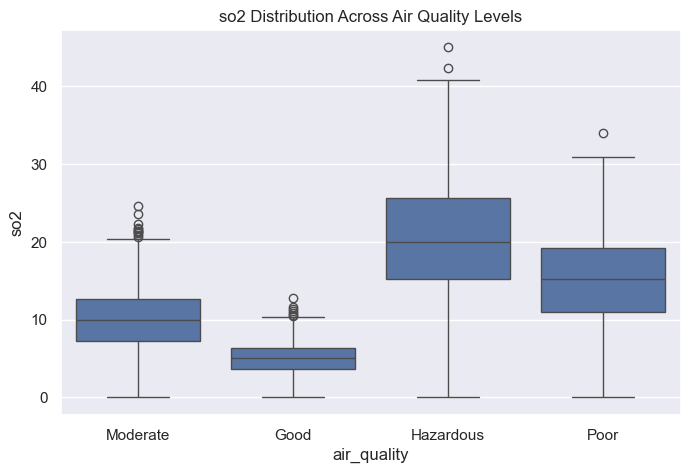

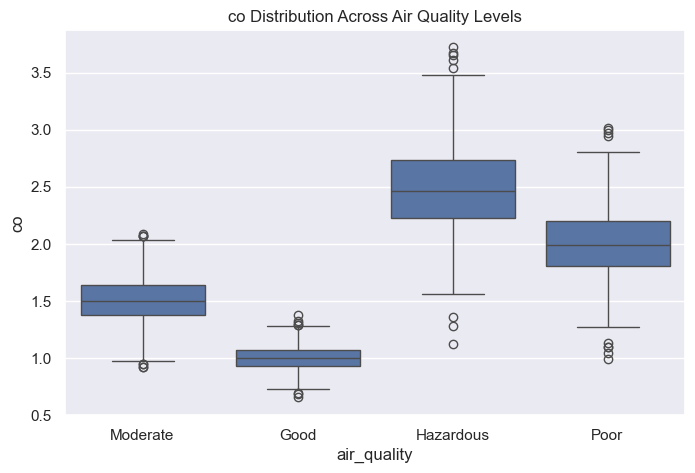

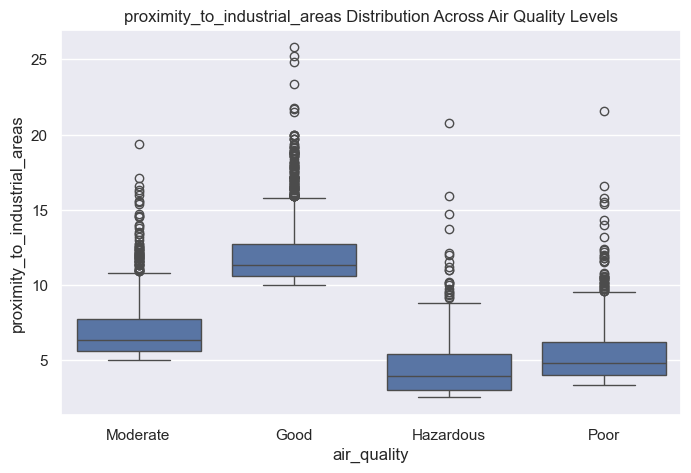

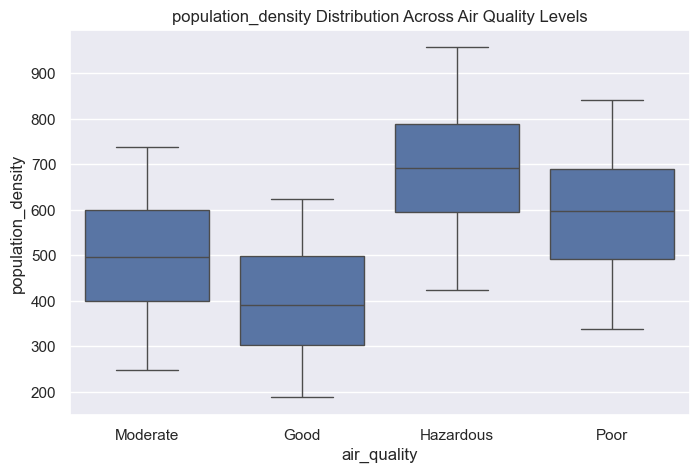

In [120]:
# Boxplots to compare numerical features across air quality levels
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="air_quality", y=feature)
    plt.title(f"{feature} Distribution Across Air Quality Levels")
    plt.show()


### Low Percentage of Outliers:

- Most features have less than 10% outliers, which is relatively small and unlikely to severely affect robust models like CatBoost, XGBoost, LightGBM, and Random Forest.
- The highest percentages are observed in PM2.5 (7.04%) and PM10 (6.48%), but these are manageable given the robustness of your chosen models.
- Given that robust models are part of the pipeline, we can choose to retain the outliers and observe how they impact model performance during validation. Removing them might lead to the loss of valuable data for extreme cases like "Hazardous."
- Since the outliers are manageable, more attention should be directed toward addressing class imbalance, especially for the "Hazardous" class, which might benefit from the presence of outliers.

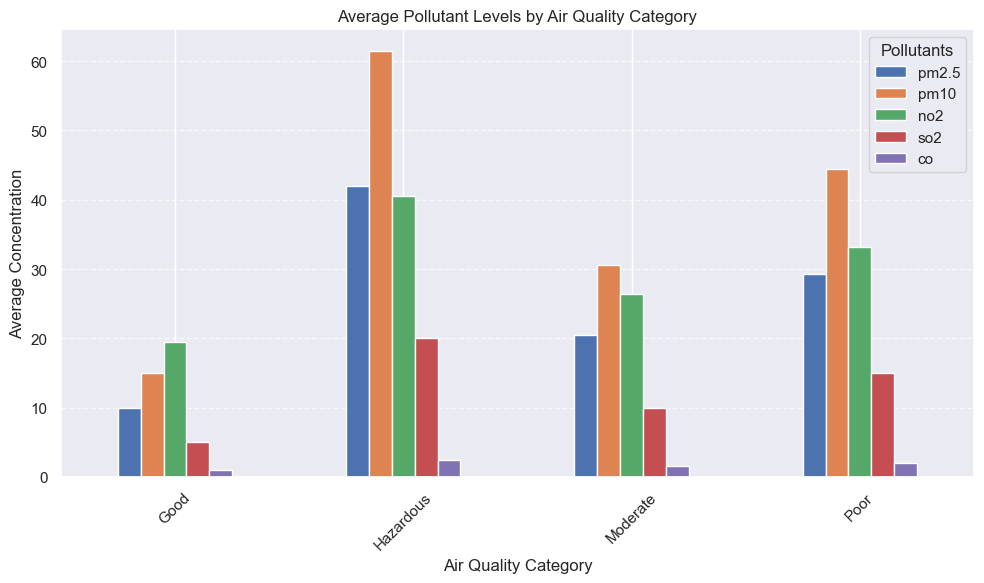

In [121]:
# Select pollutant features
pollutant_features = ['pm2.5', 'pm10', 'no2', 'so2', 'co']

# Calculate the average of pollutants by air quality
avg_pollutants = df.groupby('air_quality')[pollutant_features].mean()

# Plotting the average pollutant levels
avg_pollutants.plot(kind='bar', figsize=(10, 6))
plt.title("Average Pollutant Levels by Air Quality Category")
plt.xlabel("Air Quality Category")
plt.ylabel("Average Concentration")
plt.legend(title="Pollutants")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Insights:
- PM10 and NO2 are key indicators of deteriorating air quality. Any air quality improvement interventions should focus on reducing these pollutants.
- SO2 and CO, while less significant in the "Good" and "Moderate" categories, become more prominent as air quality worsens, making them secondary targets for interventions.
- The transition from "Poor" to "Hazardous" air quality is marked by sharp increases in multiple pollutants, indicating the cumulative effect of various sources.

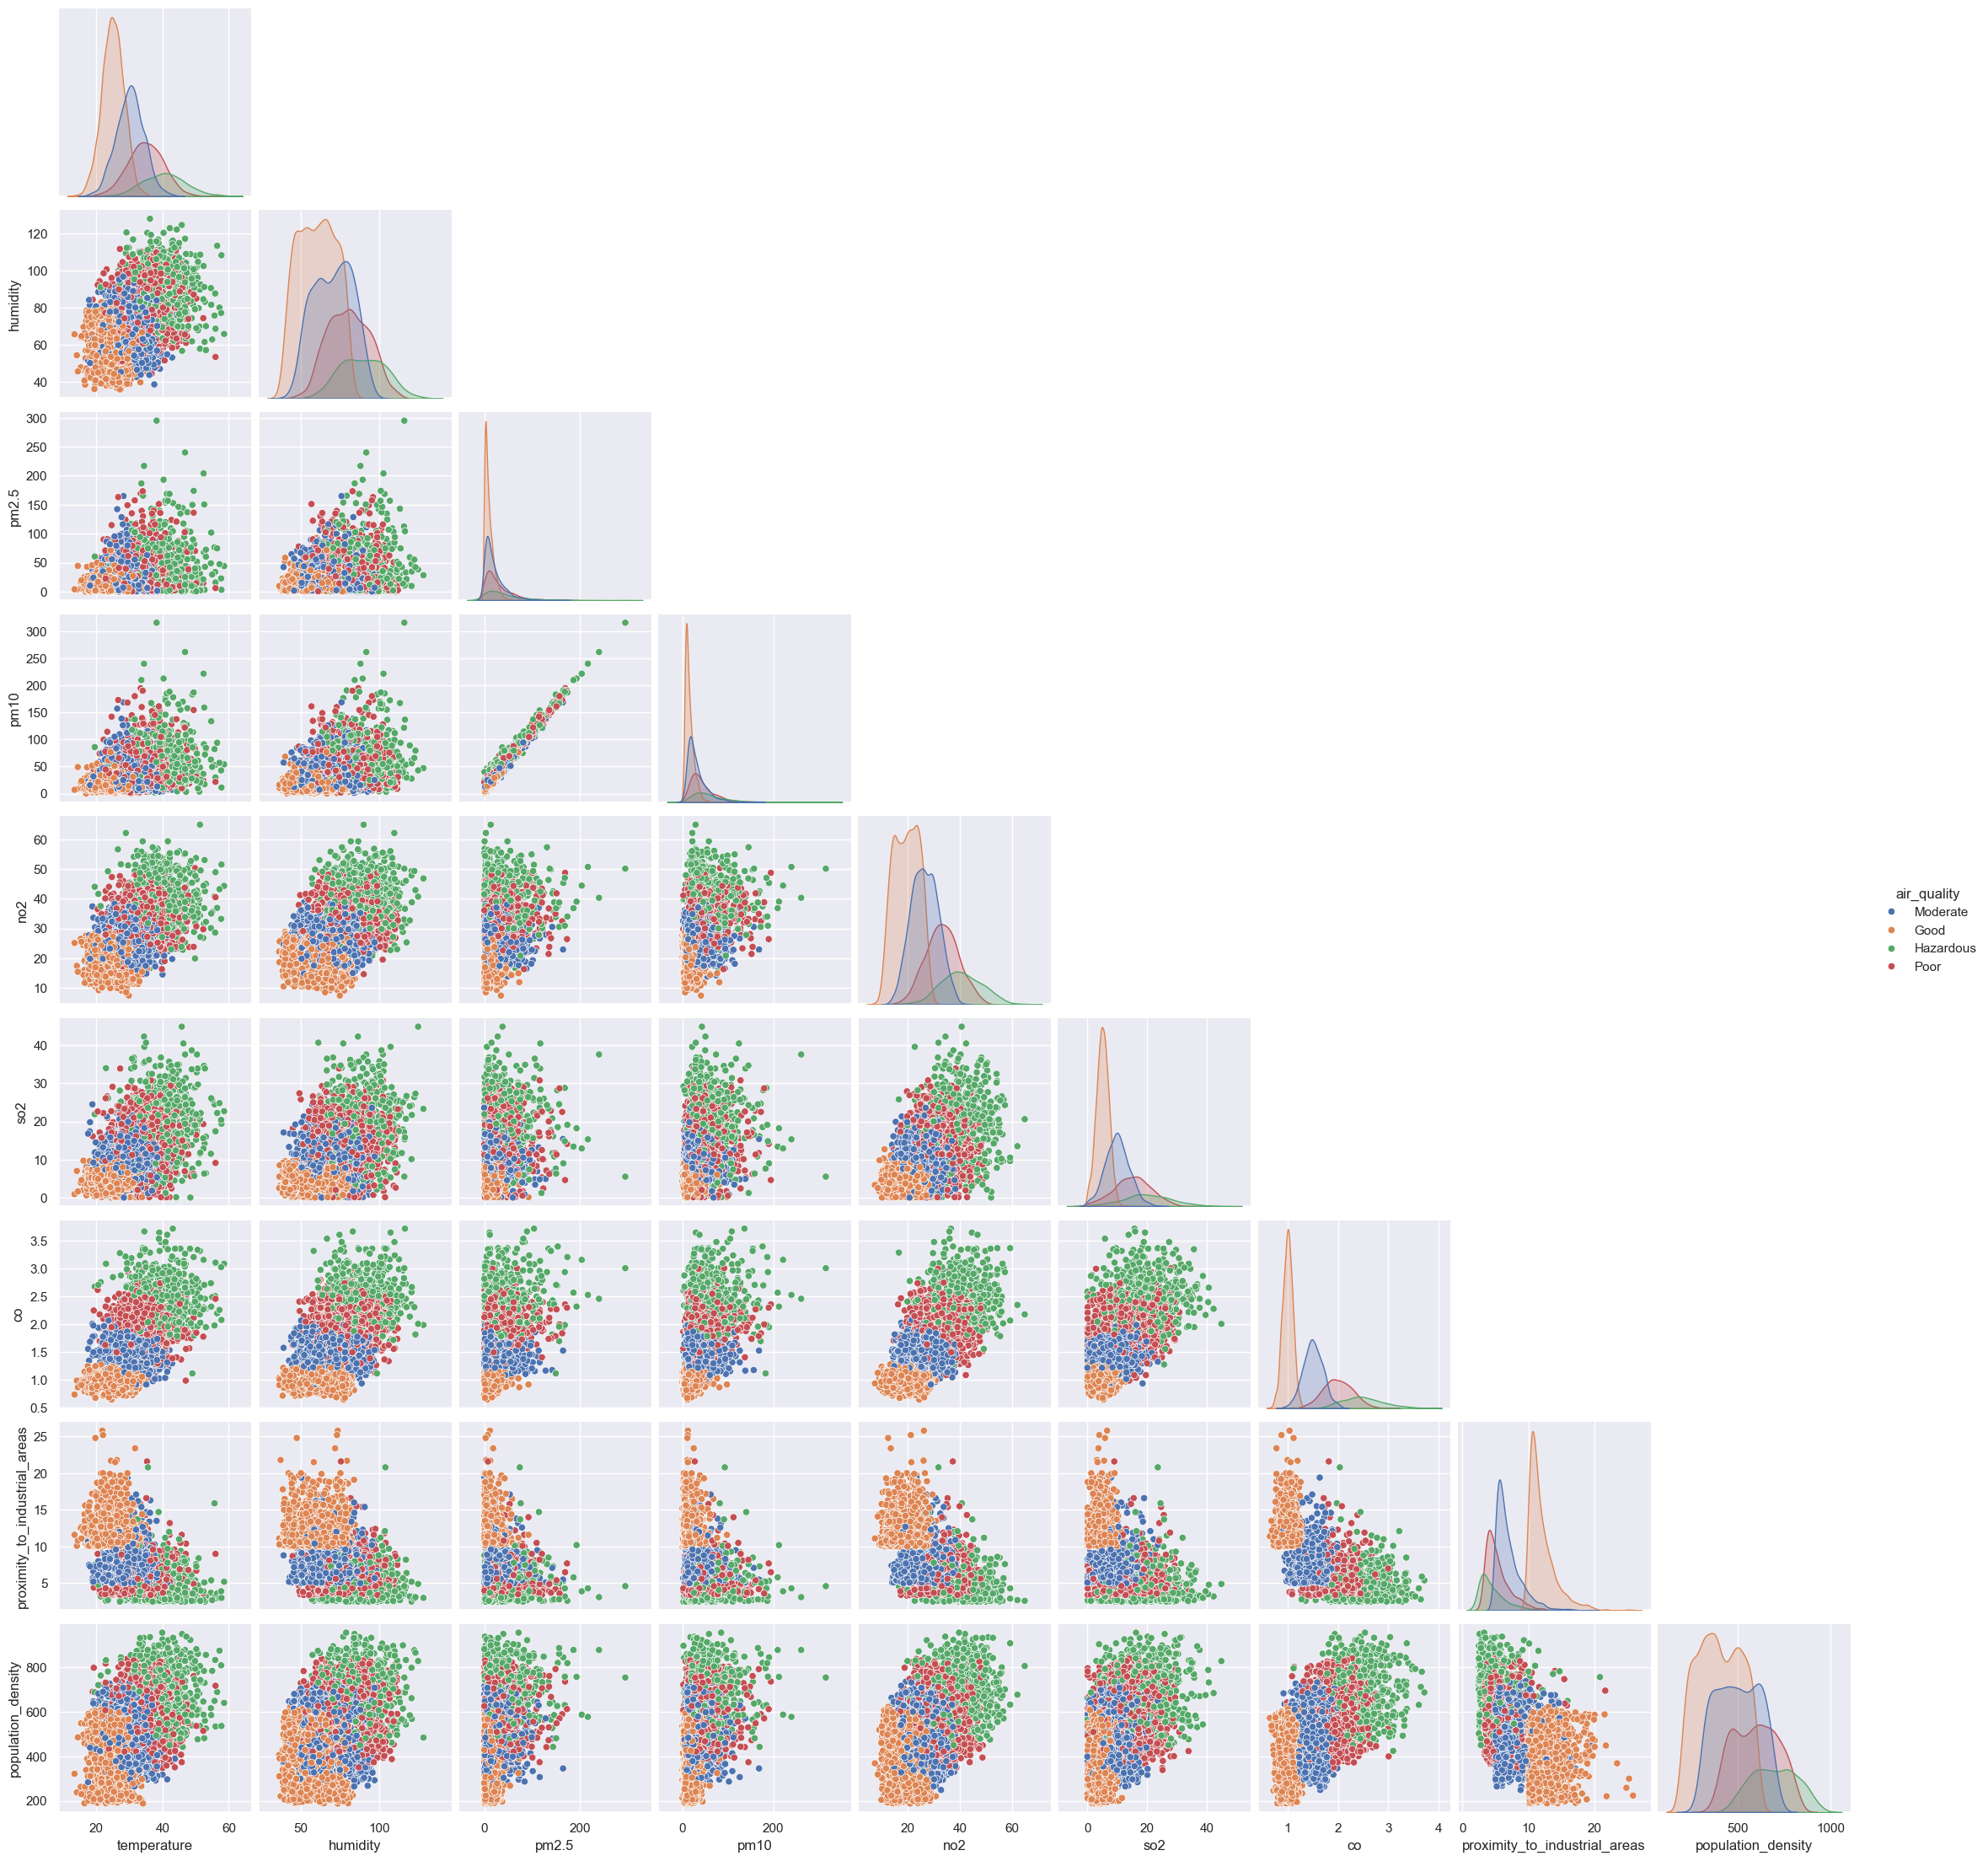

In [122]:
# Pairwise scatter plot with KDEs on the diagonal
sns.pairplot(df, hue="air_quality", diag_kind="kde", corner=True)
plt.show()


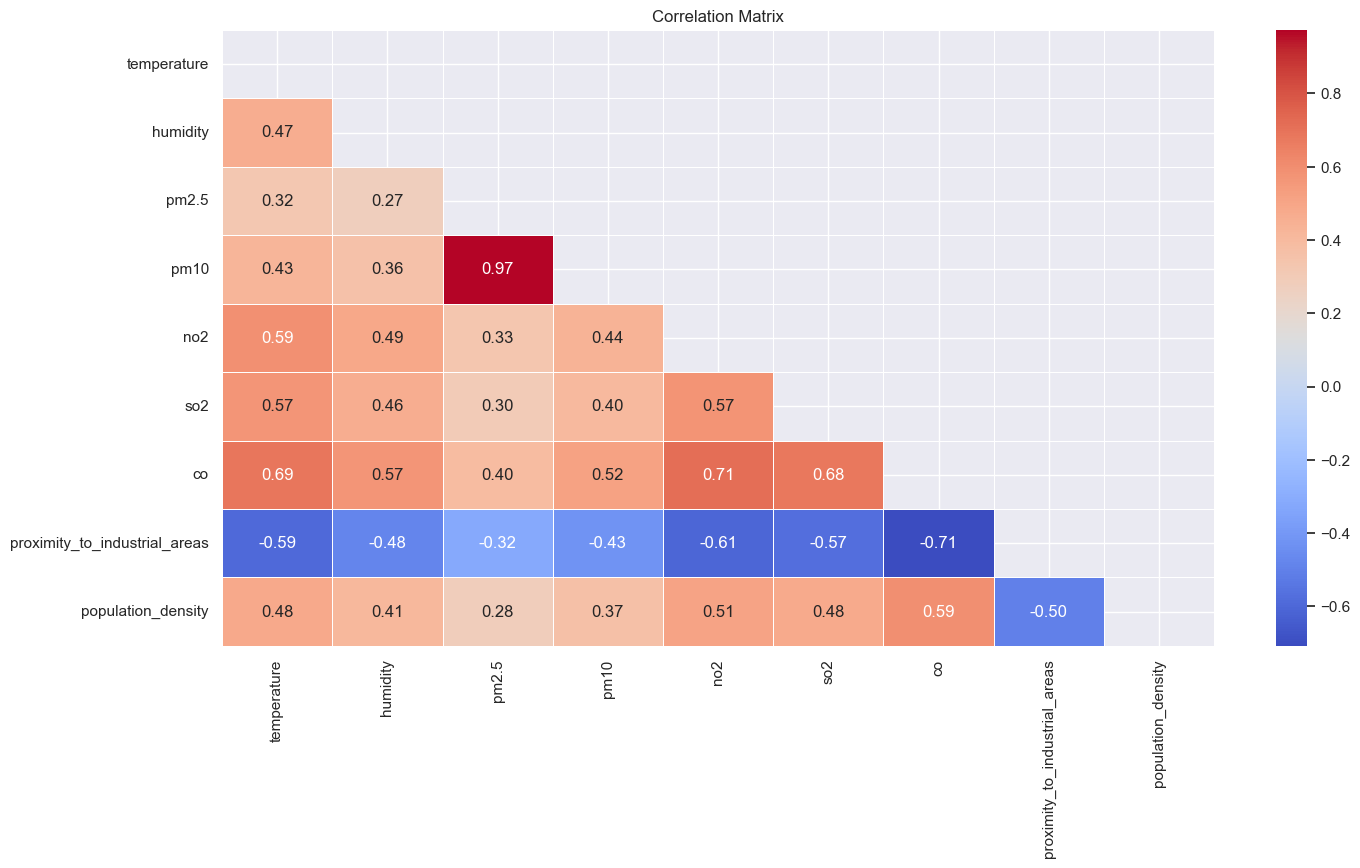

In [123]:
# Correlation Analysis
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(16, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Insights:
- Multicollinearity Management:

The high correlation between PM2.5 and PM10 suggests one of these features should be dropped (PM10 is likely the better choice for retention due to its broader coverage).
The correlation between CO, NO2, and SO2 warrants further investigation to assess redundancy in these features.

- Proximity to Industrial Areas:

This feature strongly reflects pollutant levels, supporting its importance in the model.

- Population Density:

The positive correlation with pollutants highlights urbanization as a key driver of poor air quality.

- Temperature:

The moderate correlations suggest its influence is indirect, potentially via atmospheric processes or human activity.

In [124]:
# Identify key correlated pairs (threshold > 0.8 for strong correlation)
correlation_threshold = 0.8
key_correlated_pairs = []

# Iterate over the correlation matrix and find pairs above the threshold
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            feature_1 = correlation_matrix.index[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            key_correlated_pairs.append((feature_1, feature_2, correlation_value))

# Convert to DataFrame for better readability and display
key_correlated_pairs_df = pd.DataFrame(key_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
key_correlated_pairs_df = key_correlated_pairs_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

key_correlated_pairs_df

Feature 1 Feature 2  Correlation
0     pm2.5      pm10     0.973005

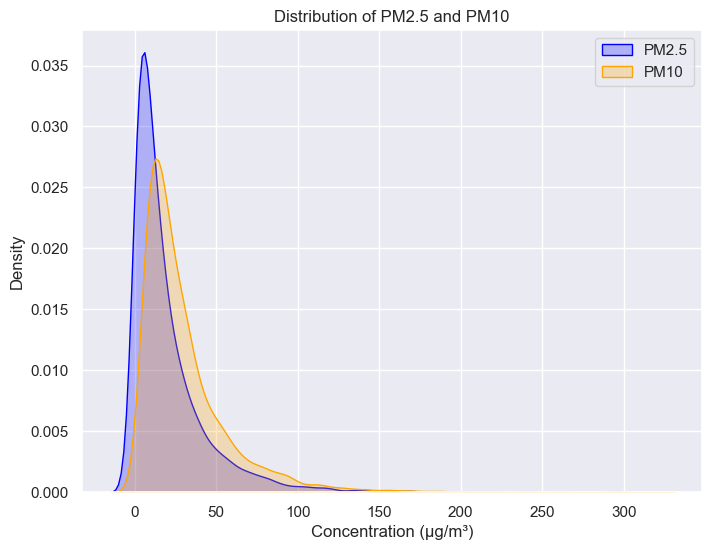

In [125]:
# KDE Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(df['pm2.5'], fill=True, label='PM2.5', color='blue')
sns.kdeplot(df['pm10'], fill=True, label='PM10', color='orange')
plt.title("Distribution of PM2.5 and PM10")
plt.xlabel("Concentration (µg/m³)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [126]:
def correlation_ratio(categories, values):
    """
    Calculate the correlation ratio (eta-squared) for a categorical target and numerical features.

    Args:
        categories (pd.Series or array-like): Categorical target variable.
        values (pd.Series or array-like): Numerical feature variable.
    
    Returns:
        float: Correlation ratio value.
    """
    categories = np.array(categories)
    values = np.array(values)
    overall_mean = np.mean(values)
    category_means = [np.mean(values[categories == category]) for category in np.unique(categories)]
    category_sizes = [np.sum(categories == category) for category in np.unique(categories)]

    between_group_variance = sum(size * (mean - overall_mean) ** 2 for size, mean in zip(category_sizes, category_means))
    total_variance = np.sum((values - overall_mean) ** 2)
    
    return between_group_variance / total_variance if total_variance > 0 else 0

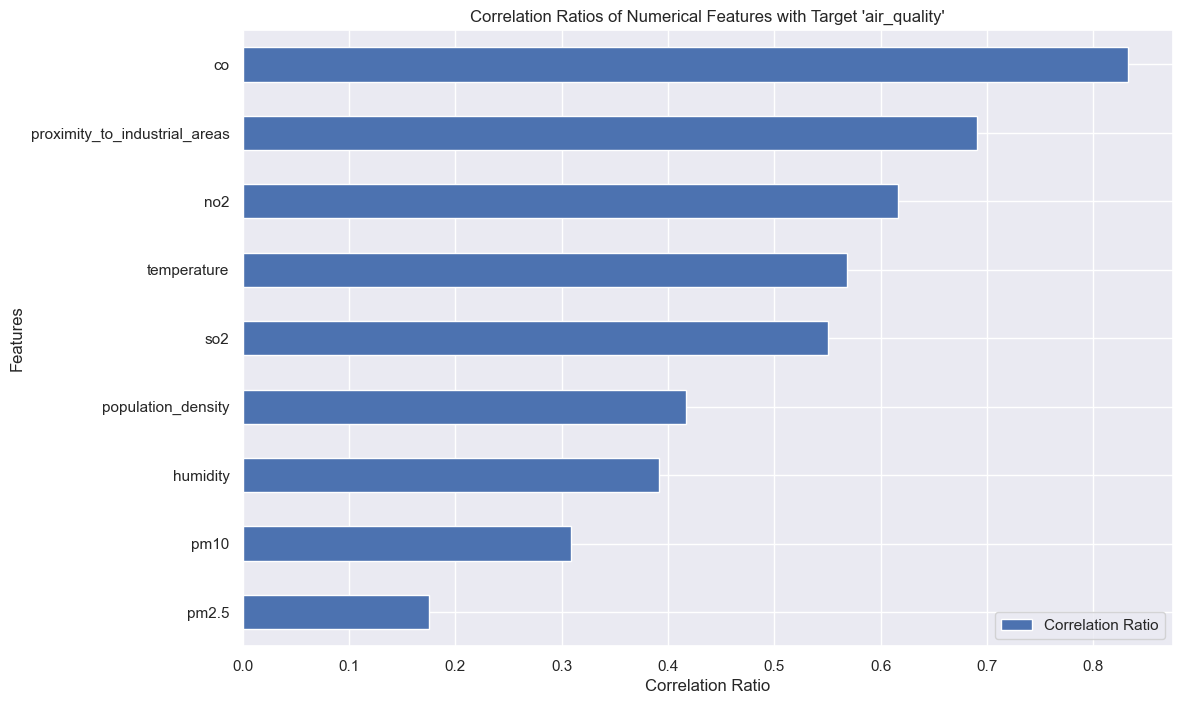

In [127]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
correlation_ratios = {}

for feature in numerical_features:
    correlation_ratios[feature] = correlation_ratio(df['air_quality'], df[feature])

# Convert to DataFrame for Sorting and Visualization
correlation_ratios_df = pd.DataFrame.from_dict(correlation_ratios, orient='index', columns=['Correlation Ratio'])
correlation_ratios_sorted = correlation_ratios_df.sort_values(by='Correlation Ratio', ascending=True)

# Plot the Correlation Ratios
correlation_ratios_sorted.plot(kind='barh', figsize=(12, 8))
plt.title("Correlation Ratios of Numerical Features with Target 'air_quality'")
plt.xlabel("Correlation Ratio")
plt.ylabel("Features")
plt.show()

### Insights:
- Key Drivers:

CO, proximity to industrial areas, and NO2 appear to be the most critical features for determining air quality.

- Weaker Features:

While PM2.5 and PM10 are traditionally strong air quality indicators, their lower correlation ratios suggest they may be less influential in this specific dataset or redundant due to collinearity.

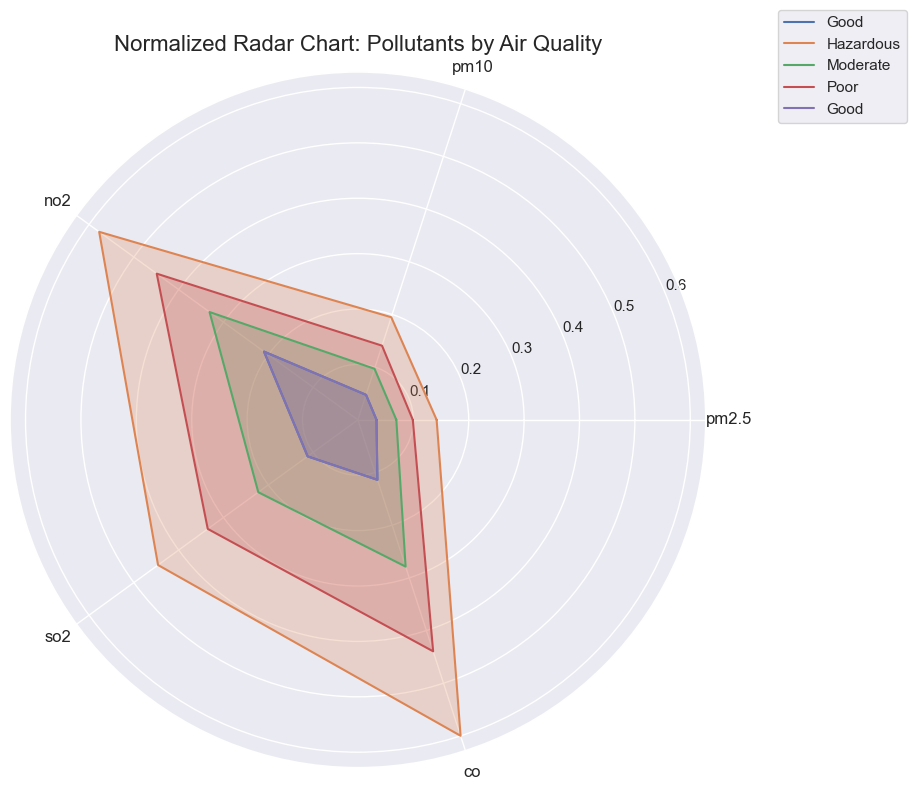

In [128]:
# Normalize the pollutant features
scaler = MinMaxScaler()
normalized_pollutants = pd.DataFrame(
    scaler.fit_transform(df[pollutant_features]),
    columns=pollutant_features,
    index=df.index
)

# Calculate the mean of normalized pollutants by air quality
avg_normalized_pollutants = (
    normalized_pollutants.join(df['air_quality'])
    .groupby('air_quality')
    .mean()
)

# Prepare data for radar chart
categories = avg_normalized_pollutants.columns
num_vars = len(categories)

# Add a row to close the circle for radar chart
avg_normalized_pollutants = pd.concat([avg_normalized_pollutants, avg_normalized_pollutants.iloc[[0]]])

# Create radar chart
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(polar=True))

# Create radar chart for each air quality category
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

for air_quality, row in avg_normalized_pollutants.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, label=air_quality)
    ax.fill(angles, values, alpha=0.25)

# Customize the chart
ax.set_title("Normalized Radar Chart: Pollutants by Air Quality", size=16)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

### Key Takeaways:
- CO as the primary driver: The chart reaffirms that CO has the most substantial influence on worsening air quality.
- NO2 and SO2 follow CO: These pollutants also rise consistently with deteriorating air quality but are less influential than CO.
- PM10 and PM2.5 are secondary in this chart: Their lower relative values in the radar chart might result from normalization, but their importance in air quality should be cross-referenced with other analyses like correlation metrics.

In [129]:
# Dropping the 'pm2.5' feature
df = df.drop(columns=['pm2.5'])

In [130]:
# Check the final column names
df.columns

Index(['temperature', 'humidity', 'pm10', 'no2', 'so2', 'co',
       'proximity_to_industrial_areas', 'population_density', 'air_quality'],
      dtype='object')

## Feature Engineering

In [131]:
# Label encoding the target variable 'air_quality'
le = LabelEncoder()
df['air_quality_encoded'] = le.fit_transform(df['air_quality'])

# Define feature set (X) and target variable (y)
X = df.drop(columns=['air_quality', 'air_quality_encoded'])
y = df['air_quality_encoded']

In [132]:
# Save the LabelEncoder
label_encoder_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\label_encoder.pkl"
joblib.dump(le, label_encoder_path)

print(f"LabelEncoder saved at: {label_encoder_path}")

LabelEncoder saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\label_encoder.pkl


In [133]:
# Split into train+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Identify numerical features for scaling
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Fit the scaler on the training data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Apply the scaler to validation and test sets
X_val_scaled = X_val.copy()
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [134]:
# Save the scaler for later use
scaler_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved at: {scaler_path}")

# Check the scaled training data
print("\nShape of scaled training data:", X_train_scaled.shape)

# Check the scaled validation data
print("Shape of scaled validation data:", X_val_scaled.shape)

# Check the scaled test data
print("Shape of scaled test data:", X_test_scaled.shape)

Scaler saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\scaler.pkl

Shape of scaled training data: (3000, 8)
Shape of scaled validation data: (1000, 8)
Shape of scaled test data: (1000, 8)


In [135]:
# Define the desired path for the processed data folder
processed_data_folder = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed"

# Ensure the processed data folder exists
os.makedirs(processed_data_folder, exist_ok=True)

# Save the datasets as CSV files
X_train_scaled.to_csv(os.path.join(processed_data_folder, "X_train_scaled.csv"), index=False)
y_train.to_csv(os.path.join(processed_data_folder, "y_train.csv"), index=False)

X_val_scaled.to_csv(os.path.join(processed_data_folder, "X_val_scaled.csv"), index=False)
y_val.to_csv(os.path.join(processed_data_folder, "y_val.csv"), index=False)

X_test_scaled.to_csv(os.path.join(processed_data_folder, "X_test_scaled.csv"), index=False)
y_test.to_csv(os.path.join(processed_data_folder, "y_test.csv"), index=False)

print("Processed datasets saved successfully in:", processed_data_folder)

Processed datasets saved successfully in: C:\Users\User\ml-zoomcamp\capstone_1\data\processed


## Modeling

In [136]:
# Define class weights for imbalanced classes
class_weights = {
    0: 1.0,  # Good
    1: 1.33,  # Moderate (2000/1500)
    2: 2.0,  # Poor (2000/1000)
    3: 4.0   # Hazardous (2000/500)
}

# Calculate sample weights for XGBoost
sample_weights = y_train.map(class_weights)

# Define a dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(force_col_wise=True, class_weight="balanced"),
    "CatBoost": CatBoostClassifier(verbose=0, class_weights=list(class_weights.values())),
    "SVM": SVC(class_weight="balanced"),
    "KNN": KNeighborsClassifier()  # KNN does not handle class weights
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    if name == "XGBoost":
        # Pass sample weights for XGBoost
        model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    else:
        # Standard fitting for other models
        model.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    
    # Compute metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    weighted_f1 = f1_score(y_val, y_val_pred, average="weighted")
    
    # Store metrics
    results[name] = {
        "Accuracy": accuracy,
        "Weighted F1-Score": weighted_f1
    }
    
    # Display metrics
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=["Good", "Moderate", "Poor", "Hazardous"]))
    print("-" * 50)

Training Logistic Regression...
Validation Accuracy: 0.9260
Weighted F1-Score: 0.9260
Classification Report:
              precision    recall  f1-score   support

        Good       0.99      0.99      0.99       391
    Moderate       0.81      0.93      0.86        86
        Poor       0.93      0.91      0.92       307
   Hazardous       0.86      0.82      0.84       216

    accuracy                           0.93      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.93      0.93      0.93      1000

--------------------------------------------------
Training Decision Tree...
Validation Accuracy: 0.9100
Weighted F1-Score: 0.9102
Classification Report:
              precision    recall  f1-score   support

        Good       0.99      0.99      0.99       391
    Moderate       0.74      0.85      0.79        86
        Poor       0.92      0.91      0.92       307
   Hazardous       0.82      0.78      0.80       216

    accuracy                  

In [155]:
# Display summary results as a table
results_df = pd.DataFrame(results).T.reset_index().sort_values(by="Weighted F1-Score", ascending=False)
results_df.columns = ["Model", "Accuracy", "Weighted F1-Score"]
print("\nModel Performance Summary:")
results_df


Model Performance Summary:


Model  Accuracy  Weighted F1-Score
6             CatBoost     0.952           0.951913
2        Random Forest     0.947           0.946675
5             LightGBM     0.943           0.942930
4              XGBoost     0.938           0.938089
3    Gradient Boosting     0.938           0.937796
7                  SVM     0.933           0.932794
8                  KNN     0.929           0.927622
0  Logistic Regression     0.926           0.925962
1        Decision Tree     0.910           0.910201

### Insights:
- CatBoost as the Best Choice:

CatBoost is the best-performing model across both metrics. Its suitability for the dataset and class imbalance makes it the ideal choice for deployment.

- Random Forest and LightGBM as Alternatives:

Random Forest and LightGBM are strong alternatives if CatBoost is not preferred due to implementation constraints.

- Metric Observations:

The Weighted F1-Score aligns well with accuracy across models, indicating that the models handle the imbalanced classes effectively. The gap between accuracy and F1-score is minimal, demonstrating that the models are consistent in handling precision and recall.

## Hyperparameter Tuning

In [166]:
def objective_catboost(trial):
    # Define the hyperparameter space
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 256),
        "class_weights": list(class_weights.values())
    }

    # Create the CatBoost model
    model = CatBoostClassifier(verbose=0, random_state=42, **params)

    # Train the model with early stopping
    model.fit(
        X_train_scaled,
        y_train,
        eval_set=(X_val_scaled, y_val),
        early_stopping_rounds=50,
        verbose=False
    )

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average="weighted")

    return weighted_f1

In [167]:
def objective_rf(trial):
    # Define the hyperparameter space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    # Create the Random Forest model
    model = RandomForestClassifier(random_state=42, class_weight="balanced", **params)
    
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average="weighted")

    return weighted_f1

In [168]:
def objective_xgb(trial):
    # Define the hyperparameter space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),  
    }

    # Create the XGBoost model
    model = XGBClassifier(eval_metric="mlogloss", random_state=42, **params)

    # Train the model
    model.fit(
        X_train_scaled,
        y_train,
        eval_set=[(X_val_scaled, y_val)],        
        verbose=False
    )

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average="weighted")

    return weighted_f1

In [169]:
def objective_lgbm(trial):
    # Define the hyperparameter space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", -1, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0)        
    }

    # Create the LightGBM model
    model = LGBMClassifier(random_state=42, class_weight="balanced", **params)

    # Train the model
    model.fit(
        X_train_scaled,
        y_train,
        eval_set=[(X_val_scaled, y_val)]
    )

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    weighted_f1 = f1_score(y_val, y_val_pred, average="weighted")

    return weighted_f1

In [170]:
# Run Optuna for each model
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(objective_catboost, n_trials=50, show_progress_bar=True, n_jobs=-1)

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True, n_jobs=-1)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True, n_jobs=-1)

study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True, n_jobs=-1)

# Display best parameters and weighted F1-score for each model
print("Best CatBoost:", study_catboost.best_params, "Weighted F1-Score:", study_catboost.best_value)
print("Best Random Forest:", study_rf.best_params, "Weighted F1-Score:", study_rf.best_value)
print("Best XGBoost:", study_xgb.best_params, "Weighted F1-Score:", study_xgb.best_value)
print("Best LightGBM:", study_lgbm.best_params, "Weighted F1-Score:", study_lgbm.best_value)

[I 2025-01-03 19:49:43,440] A new study created in memory with name: no-name-f45e1543-81a4-4a8b-b93f-5435a0b3b790


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-03 19:49:50,079] Trial 0 finished with value: 0.9286876682771026 and parameters: {'iterations': 454, 'depth': 5, 'learning_rate': 0.011547506109253853, 'l2_leaf_reg': 7.872204440208347, 'border_count': 70}. Best is trial 0 with value: 0.9286876682771026.
[I 2025-01-03 19:50:00,544] Trial 2 finished with value: 0.9538716216216216 and parameters: {'iterations': 1191, 'depth': 6, 'learning_rate': 0.043671517787150296, 'l2_leaf_reg': 2.6084063459380555, 'border_count': 188}. Best is trial 2 with value: 0.9538716216216216.
[I 2025-01-03 19:50:03,783] Trial 1 finished with value: 0.9527929517800665 and parameters: {'iterations': 443, 'depth': 8, 'learning_rate': 0.1898541046508116, 'l2_leaf_reg': 7.1071025708405715, 'border_count': 156}. Best is trial 2 with value: 0.9538716216216216.
[I 2025-01-03 19:50:09,201] Trial 4 finished with value: 0.949735479070817 and parameters: {'iterations': 675, 'depth': 8, 'learning_rate': 0.18663669099548333, 'l2_leaf_reg': 4.3202778573954, 'borde

[I 2025-01-03 19:56:56,594] A new study created in memory with name: no-name-07a3e692-acf9-4a76-bab6-a93437fd70da


[I 2025-01-03 19:56:56,582] Trial 49 finished with value: 0.9489452351959115 and parameters: {'iterations': 343, 'depth': 10, 'learning_rate': 0.2396727119636903, 'l2_leaf_reg': 6.663222124183063, 'border_count': 236}. Best is trial 18 with value: 0.9578303343361525.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-03 19:57:02,801] Trial 0 finished with value: 0.9430345280871422 and parameters: {'n_estimators': 195, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9430345280871422.
[I 2025-01-03 19:57:07,600] Trial 3 finished with value: 0.9469191074638188 and parameters: {'n_estimators': 369, 'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9469191074638188.
[I 2025-01-03 19:57:09,770] Trial 2 finished with value: 0.9479771453733477 and parameters: {'n_estimators': 476, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9479771453733477.
[I 2025-01-03 19:57:10,372] Trial 4 finished with value: 0.943038645202565 and parameters: {'n_estimators': 303, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.947977145373347

[I 2025-01-03 19:59:44,890] A new study created in memory with name: no-name-6b7bf1b5-50e2-49fe-8daf-da17033214bf


[I 2025-01-03 19:59:44,884] Trial 49 finished with value: 0.943996332814392 and parameters: {'n_estimators': 642, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 8 with value: 0.9489666576268759.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-03 19:59:48,787] Trial 1 finished with value: 0.9438347399292846 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.10436796522196401, 'subsample': 0.8312099562805715, 'colsample_bytree': 0.5058700949649415, 'reg_alpha': 1.0711934976696302, 'reg_lambda': 5.186900866956697, 'scale_pos_weight': 5.925446048296711}. Best is trial 1 with value: 0.9438347399292846.
[I 2025-01-03 19:59:49,825] Trial 4 finished with value: 0.9375886000935388 and parameters: {'n_estimators': 57, 'max_depth': 6, 'learning_rate': 0.04129439227974121, 'subsample': 0.9234065807428429, 'colsample_bytree': 0.7166788120295431, 'reg_alpha': 3.5827908960870403, 'reg_lambda': 7.687362040442865, 'scale_pos_weight': 4.646465125328022}. Best is trial 1 with value: 0.9438347399292846.
[I 2025-01-03 19:59:49,940] Trial 3 finished with value: 0.9436141436819249 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.014872240446046467, 'subsample': 0.540850272750381, 'colsamp

[I 2025-01-03 20:01:02,708] A new study created in memory with name: no-name-9f1715d8-94fc-4fed-9780-892631ef1816


[I 2025-01-03 20:01:02,702] Trial 49 finished with value: 0.946562292294228 and parameters: {'n_estimators': 535, 'max_depth': 5, 'learning_rate': 0.01167081348329864, 'subsample': 0.5279223424609325, 'colsample_bytree': 0.525518961727616, 'reg_alpha': 8.985183735454655, 'reg_lambda': 5.558625301131831, 'scale_pos_weight': 7.716997337685366}. Best is trial 44 with value: 0.949714372383668.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-03 20:01:08,516] Trial 3 finished with value: 0.9469361190190417 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.010940589107889483, 'num_leaves': 63, 'subsample': 0.7646734199091438, 'colsample_bytree': 0.5230151868654707, 'reg_alpha': 4.513838950555918, 'reg_lambda': 7.318606474519248}. Best is trial 3 with value: 0.9469361190190417.
[I 2025-01-03 20:01:09,368] Trial 2 finished with value: 0.9368794397793752 and parameters: {'n_estimators': 195, 'max_depth': 17, 'learning_rate': 0.013064127617572146, 'num_leaves': 76, 'subsample': 0.826854311825957, 'colsample_bytree': 0.7095519373409767, 'reg_alpha': 0.11328107954009847, 'reg_lambda': 4.92850177612337}. Best is trial 3 with value: 0.9469361190190417.
[I 2025-01-03 20:01:14,198] Trial 5 finished with value: 0.9260190299520928 and parameters: {'n_estimators': 123, 'max_depth': 23, 'learning_rate': 0.013268632504332226, 'num_leaves': 124, 'subsample': 0.9511680419659654, 'colsample_bytree': 0.6950874

In [171]:
# Prepare a table summarizing the best results from Optuna
tuning_results = {
    "Model": ["CatBoost", "Random Forest", "XGBoost", "LightGBM"],
    "Best Weighted F1-Score": [
        study_catboost.best_value,
        study_rf.best_value,
        study_xgb.best_value,
        study_lgbm.best_value,
    ],
    "Best Parameters": [
        study_catboost.best_params,
        study_rf.best_params,
        study_xgb.best_params,
        study_lgbm.best_params,
    ]
}

# Convert to DataFrame
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df = tuning_results_df.sort_values(by="Best Weighted F1-Score", ascending=False)
tuning_results_df

Model  Best Weighted F1-Score  \
0       CatBoost                0.957830   
2        XGBoost                0.949714   
3       LightGBM                0.949076   
1  Random Forest                0.948967   

                                     Best Parameters  
0  {'iterations': 1236, 'depth': 6, 'learning_rat...  
2  {'n_estimators': 537, 'max_depth': 6, 'learnin...  
3  {'n_estimators': 650, 'max_depth': 33, 'learni...  
1  {'n_estimators': 788, 'max_depth': 22, 'min_sa...

In [178]:
# Merging both tables of initial and tuned results for comparison
merged_results_df = pd.merge(
    results_df,
    tuning_results_df,
    on="Model",
    how="inner"
).sort_values(by="Weighted F1-Score", ascending=False)

merged_results_df

Model  Accuracy  Weighted F1-Score  Best Weighted F1-Score  \
0       CatBoost     0.952           0.951913                0.957830   
1  Random Forest     0.947           0.946675                0.948967   
2       LightGBM     0.943           0.942930                0.949076   
3        XGBoost     0.938           0.938089                0.949714   

                                     Best Parameters  
0  {'iterations': 1236, 'depth': 6, 'learning_rat...  
1  {'n_estimators': 788, 'max_depth': 22, 'min_sa...  
2  {'n_estimators': 650, 'max_depth': 33, 'learni...  
3  {'n_estimators': 537, 'max_depth': 6, 'learnin...

### Insights:

- CatBoost Advantage: CatBoost edges ahead due to its efficient handling of categorical data and robust learning process. The higher Weighted F1-Score indicates it handles class imbalance better than the alternatives.

- Boosting Models Perform Better: XGBoost and LightGBM are close contenders, demonstrating that gradient boosting frameworks are well-suited for this dataset.

- Random Forest’s Consistency: Random Forest performs comparably, but its reliance on bagging rather than boosting might explain its marginally lower score.

Our Approach:

- Deploy CatBoost: Given its top performance and efficiency with imbalanced datasets, CatBoost will be selected for final deployment.
- XGBoost as an Alternative: XGBoost offers a strong alternative if CatBoost is not feasible for some reason.
- LightGBM and Random Forest as Backup: These models provide reliable options with competitive performance.

In [172]:
# Identify the best model
best_model_index = tuning_results_df["Best Weighted F1-Score"].idxmax()
best_model_name = tuning_results_df.loc[best_model_index, "Model"]
best_model_params = tuning_results_df.loc[best_model_index, "Best Parameters"]
best_model_f1 = tuning_results_df.loc[best_model_index, "Best Weighted F1-Score"]

print(f"Best Model: {best_model_name}")
print(f"Best Weighted F1-Score: {best_model_f1:.4f}")
print(f"Best Parameters: {best_model_params}")

Best Model: CatBoost
Best Weighted F1-Score: 0.9578
Best Parameters: {'iterations': 1236, 'depth': 6, 'learning_rate': 0.29335655105586117, 'l2_leaf_reg': 3.3560556586760066, 'border_count': 168}


## Evaluate Best Model on Test Set

In [173]:
# Combine training and validation sets for final training
X_train_final = pd.concat([X_train_scaled, X_val_scaled])
y_train_final = pd.concat([y_train, y_val])

# Train the CatBoost model with the best parameters
best_catboost_model = CatBoostClassifier(verbose=0, random_state=42, **best_model_params)
best_catboost_model.fit(X_train_final, y_train_final)

# Evaluate on test set
y_test_pred = best_catboost_model.predict(X_test_scaled)
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Weighted F1-Score on Test Set: {weighted_f1:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))       

Weighted F1-Score on Test Set: 0.9521
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.91      0.86      0.88       111
           2       0.96      0.96      0.96       294
           3       0.86      0.89      0.87       186

    accuracy                           0.95      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.95      0.95      0.95      1000



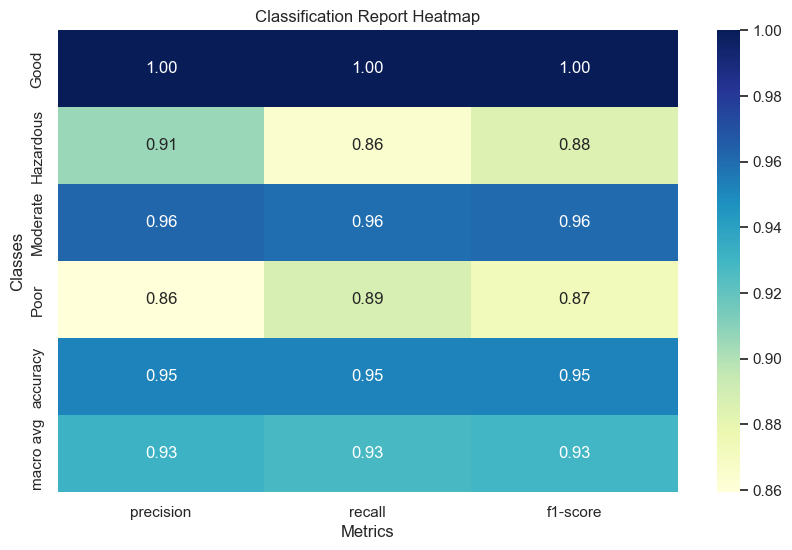

In [174]:
# Generate the classification report as a dictionary
report = classification_report(y_test, y_test_pred, target_names=le.classes_, output_dict=True)

# Convert the report into a DataFrame for visualization
report_df = pd.DataFrame(report).T

# Remove support column
if 'support' in report_df.columns:
    report_df = report_df.drop(columns=['support'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :], annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

## Save for Reproducibility

In [175]:
# Save the best model
best_model_path = r"C:\Users\User\ml-zoomcamp\capstone_1\models\best_model.pkl"
joblib.dump(best_catboost_model, best_model_path)
print(f"Best Model saved at: {best_model_path}")

# Save the processed datasets for reproducibility during inference
X_train_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\X_train.pkl"
X_val_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\X_val.pkl"
X_test_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\X_test.pkl"
y_train_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\y_train.pkl"
y_val_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\y_val.pkl"
y_test_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\y_test.pkl"

joblib.dump(X_train_scaled, X_train_path)
joblib.dump(X_val_scaled, X_val_path)
joblib.dump(X_test_scaled, X_test_path)
joblib.dump(y_train, y_train_path)
joblib.dump(y_val, y_val_path)
joblib.dump(y_test, y_test_path)

print("Processed datasets saved successfully in:", processed_data_folder)   

# Save the best parameters and metrics for reproducibility during inference
best_params_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_params.pkl"
best_f1_path = r"C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_f1.pkl"
joblib.dump(best_model_params, best_params_path)
joblib.dump(best_model_f1, best_f1_path)

print(f"Best Parameters saved at: {best_params_path}")
print(f"Best F1-Score saved at: {best_f1_path}")

print("Best parameters and metrics saved successfully in:", processed_data_folder)

Best Model saved at: C:\Users\User\ml-zoomcamp\capstone_1\models\best_model.pkl
Processed datasets saved successfully in: C:\Users\User\ml-zoomcamp\capstone_1\data\processed
Best Parameters saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_params.pkl
Best F1-Score saved at: C:\Users\User\ml-zoomcamp\capstone_1\data\processed\best_f1.pkl
Best parameters and metrics saved successfully in: C:\Users\User\ml-zoomcamp\capstone_1\data\processed


## Conclusion and Next Steps

The goal of this project was to predict air quality levels using various machine learning models, evaluate their performance, and optimize the best-performing models using hyperparameter tuning. 

### Key findings include:

- **Best Performing Model**: CatBoost emerged as the best model with an initial Weighted F1-Score of 0.951913, which improved to 0.957830 after hyperparameter tuning. This highlights its robustness and ability to handle imbalanced datasets effectively.
- **Competitors**:
LightGBM and XGBoost showed notable improvements post-tuning, achieving Weighted F1-Scores of 0.949076 and 0.949714, respectively.
These models can be considered strong alternatives for specific use cases.
- **Random Forest**: While Random Forest performed well with a Weighted F1-Score of 0.948967, its improvement post-tuning was relatively modest compared to LightGBM and XGBoost.
- **Feature Contributions**: Carbon Monoxide (CO) and proximity to industrial areas emerged as the most critical features for predicting air quality, validated through correlation analysis, feature importance scores, and exploratory data visualizations.
- **Handling Outliers**: Outliers were retained during modeling due to the robustness of tree-based models like CatBoost and LightGBM, which are less sensitive to extreme values.
- **Imbalanced Dataset**: The models successfully handled the class imbalance by applying class weights and using metrics such as the Weighted F1-Score to ensure fair evaluation across all air quality categories.

### Next Steps:

1. train.py:

- Objective: Automate the training pipeline based on the finalized notebook.
- Steps:
    - Load the processed training data and optimal hyperparameters (best_params.pkl).
    - Train the final CatBoost model using combined training and validation datasets.
    - Save the trained model (best_model.pkl) for deployment.

2. predict.py:

- Objective: Implement an inference pipeline for real-time predictions.
- Steps:
    - Load the saved model and scaler (best_model.pkl and scaler.pkl).
    - Define an API endpoint for prediction using FastAPI.
    - Ensure inputs are preprocessed in the same way as during training.

3. Model Deployment:

- Containerization:
    - Create a Dockerfile to containerize the web service.
    - Ensure all dependencies (requirements.txt, scaler.pkl, best_model.pkl) are included in the image.
- Cloud Deployment:
    - Deploy the containerized application on a cloud service provider, using Kubernetes for orchestration.
    - Implement autoscaling and health checks using Kubernetes features.

